LaTeX macros (hidden cell)
$
\newcommand{\Q}{\mathcal{Q}}
\newcommand{\ECov}{\boldsymbol{\Sigma}}
\newcommand{\EMean}{\boldsymbol{\mu}}
\newcommand{\EAlpha}{\boldsymbol{\alpha}}
\newcommand{\EBeta}{\boldsymbol{\beta}}
$

# Imports and configuration

In [8]:
import sys
import os
import re
import glob
import datetime as dt

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

from notebook.services.config import ConfigManager

from portfolio_tools import data_download, DataReader

In [9]:
# Version checks
print(sys.version)
print('matplotlib: {}'.format(matplotlib.__version__))

# Jupyter configuration
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})  

# Numpy options
np.set_printoptions(precision=5, linewidth=120, suppress=True)

# Pandas options
pd.set_option('display.max_rows', None)

# Matplotlib options
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


# Define the optimization model

We create a function to randomize factor models, i. e., large random covariance matrices with only a few significant eigenvalues.

In [10]:
def random_factor_model(N, K, T):
    # Generate K uncorrelated, zero mean factors, with weighted variance
    S_F = np.diag(range(1, K + 1))
    Z_F = np.random.default_rng(seed=1).multivariate_normal(np.zeros(K), S_F, T).T

    # Generate random factor model parameters
    B = np.random.default_rng(seed=2).normal(size=(N, K))
    a = np.random.default_rng(seed=3).normal(loc=1, size=(N, 1))
    e = np.random.default_rng(seed=4).multivariate_normal(np.zeros(N), np.eye(N), T).T

    # Generate N time-series from the factors
    Z = a + B @ Z_F + e
    
    # Residual covariance
    S_theta = np.cov(e)
    diag_S_theta = np.diag(S_theta)

    # Optimization parameters
    m = np.mean(Z, axis=1)
    S = np.cov(Z)
    #print(np.linalg.eigvalsh(np.corrcoef(Z))[-20:])
    
    return m, S, B, S_F, diag_S_theta

Here we define the optimization model in MOSEK Fusion.

In [11]:
# Solve optimization
def Markowitz(N, m, G, gamma2):
    with Model("markowitz") as M:
        # Settings
        #M.setLogHandler(sys.stdout) 

        # Decision variable (fraction of holdings in each security)
        # The variable x is restricted to be positive, which imposes the constraint of no short-selling.   
        x = M.variable("x", N, Domain.greaterThan(0.0))

        # Budget constraint
        M.constraint('budget', Expr.sum(x), Domain.equalsTo(1))

        # Objective 
        M.objective('obj', ObjectiveSense.Maximize, Expr.dot(m, x))

        # Imposes a bound on the risk
        if isinstance(G, tuple):
            G_factor = G[0]
            g_specific = G[1]
            
            factor_risk = Expr.mul(G_factor.T, x) 
            specific_risk = Expr.mulElm(g_specific, x)
            total_risk = Expr.vstack(factor_risk, specific_risk)
            
            M.constraint('risk', Expr.vstack(np.sqrt(gamma2), total_risk), Domain.inQCone())
        else:
            M.constraint('risk', Expr.vstack(np.sqrt(gamma2), Expr.mul(G.T, x)), Domain.inQCone())

        # Solve optimization
        M.solve()
        
        # Check if the solution is an optimal point
        solsta = M.getPrimalSolutionStatus()
        if (solsta != SolutionStatus.Optimal):
            # See https://docs.mosek.com/latest/pythonfusion/accessing-solution.html about handling solution statuses.
            raise Exception("Unexpected solution status!") 
        
        returns = M.primalObjValue()
        portfolio = x.level()
        time = M.getSolverDoubleInfo("optimizerTime")
        
        return returns, time

# Run the optimization

## Define the parameters

The parameters are the number of factors $K$ and the risk limit $\gamma^2$.

In [12]:
# Risk limit
gamma2 = 0.1

# Number of factors
K = 10

## Solve the optimization problem

Next we generate random factor structured covariance matrices of different sizes, and solve the portfolio optimization both when we utilize the factor structure and when we do Cholesky factorization on it instead.

In [13]:
# Generate runtime data 
# NOTE: This can have a long runtime, depending on the range given for n below!
list_runtimes_orig = []
list_runtimes_factor = []
for n in range(5, 13):
    N = 2**n
    T = N + 2**(n-1)
    m, S, B, S_F, diag_S_theta = random_factor_model(N, K, T)

    F = np.linalg.cholesky(S_F)
    G_factor = B @ F
    g_specific = np.sqrt(diag_S_theta)
    
    G_orig = np.linalg.cholesky(S)
        
    optimum_orig, runtime_orig = Markowitz(N, m, G_orig, gamma2)
    optimum_factor, runtime_factor = Markowitz(N, m, (G_factor, g_specific), gamma2)
    list_runtimes_orig.append((N, runtime_orig))
    list_runtimes_factor.append((N, runtime_factor))
    
tup_N_orig, tup_time_orig = list(zip(*list_runtimes_orig))
tup_N_factor, tup_time_factor = list(zip(*list_runtimes_factor))

# Plot results

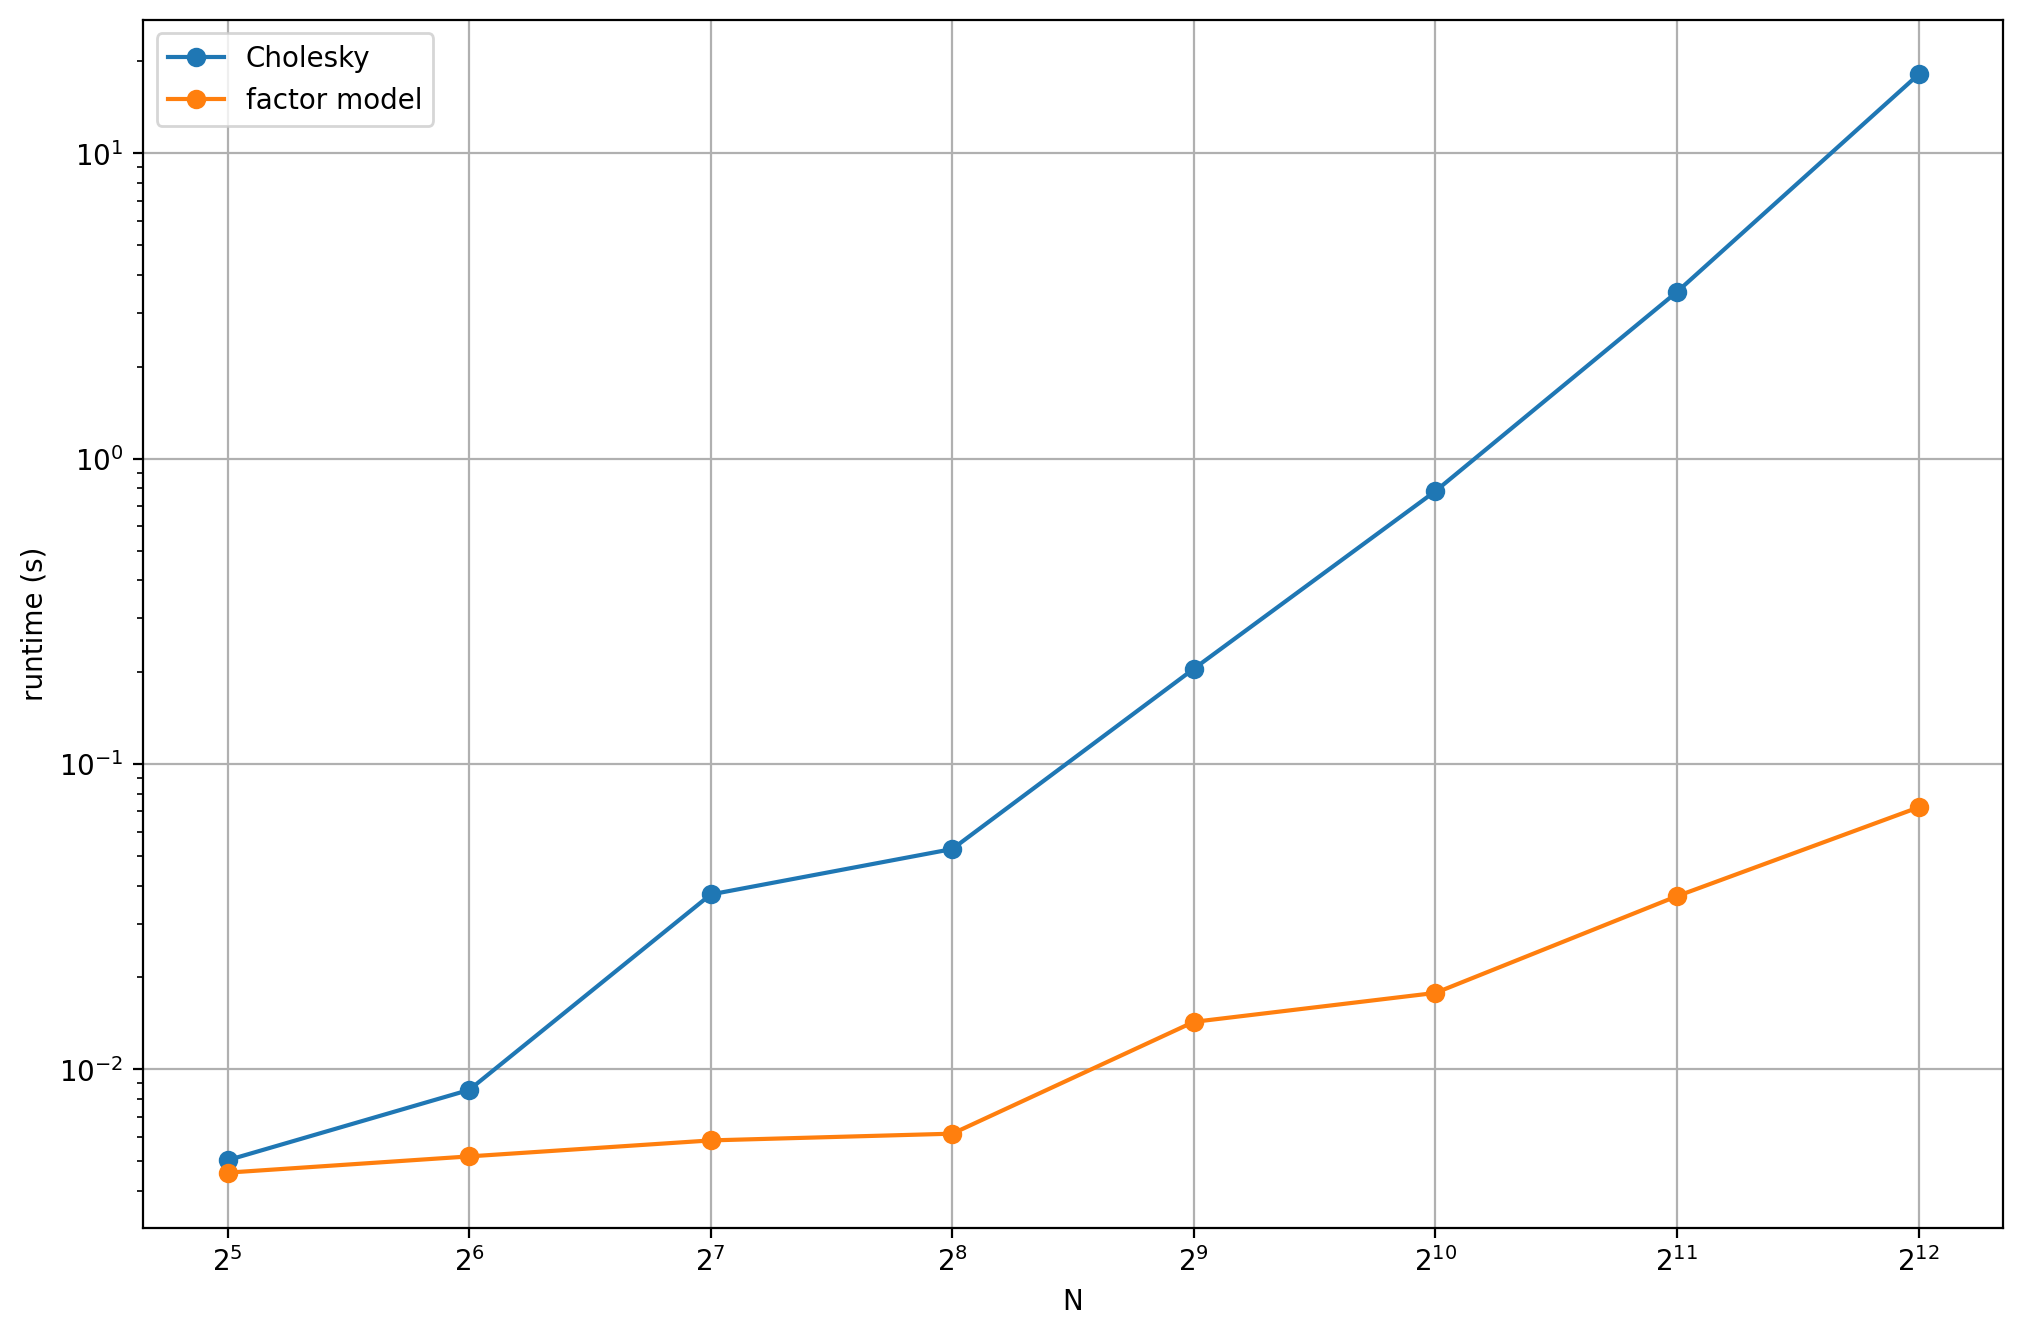

In [14]:
# Runtime plot
plt.plot(tup_N_orig, tup_time_orig, "-o")
plt.plot(tup_N_factor, tup_time_factor, "-o")
plt.xlabel("N")
plt.ylabel("runtime (s)")
ax = plt.gca()
ax.set_xscale('log', base=2)
ax.set_yscale('log')
ax.grid()
legend = ["Cholesky", "factor model"]
plt.legend(legend)